## Code for global prevalence

In [ ]:
!pip install rpy2

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(stats)
library(psych)
library(regclass)
library(BBmisc)
library(tidyverse)
library(ggplot2)
library(ggpubr)
library(MuMIn)
library(vegan)
library(pROC)
library(ROCR)
library(lme4)
library(car)
library(ape)
library(geiger)
library(caper)
library(phytools)
library(adephylo)
library(phylobase)
library(picante)
library(phangorn)
library(phyr)
library(factoextra)
library(glmmTMB)
library(lctools)
library(spdep)
library(spatialreg)
library(fmesher)
library(INLA)
library(MCMCglmm)
library(brms)
library(loo)


In [ ]:
%%R
## Gettign data
data <- read.csv("/Final3.csv")

In [ ]:
%%R
colnames(data)

 [1] "X"                  "Host.family"        "Avian.host.species"
 [4] "Latitude"           "Longitude"          "Country"           
 [7] "Year"               "Isolation.source"   "Protocol"          
[10] "Data.source"        "Plasmodium"         "Parahaemoproteus"  
[13] "Haemoproteus"       "Leucocytozoon"      "Site"              
[16] "MigrationDist"      "Canopy"             "Mass"              
[19] "ForestCover_2"      "ForestCover"        "Abundance"         
[22] "HB1"                "HB2"                "HB3"               
[25] "HB4"                "Clima_1"            "Clima_2"           
[28] "Clima_3"            "Clima_4"            "Elevacao"          
[31] "Wetland"            "Speciesdiversity"   "Node_date"         
[34] "Node_date2"         "PCHB1"              "phylo_id"          
[37] "animal"            


In [ ]:
%%R
## Phylogeny
phylogeny <- read.nexus("/output.nex")
phylogeny <- maxCladeCred(phylogeny,rooted=FALSE)

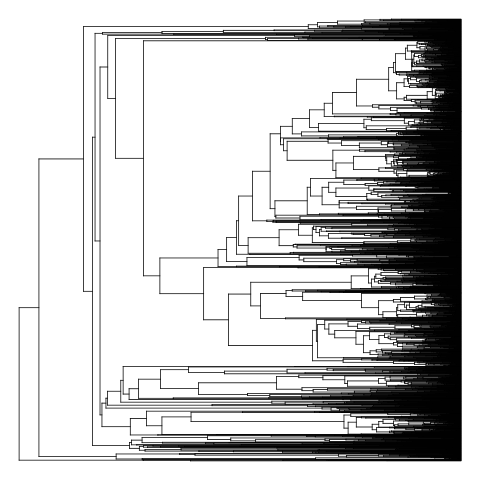

In [ ]:
%%R
plotTree(phylogeny, ftype="off", fsize=0.5,lwd=1,offset=0.5)

In [ ]:
%%R
## Checking
all(phylogeny$tip.label %in% unique(data$Avian.host.species))

[1] FALSE


In [ ]:
%%R
## Checking
all(unique(data$Avian.host.species) %in% phylogeny$tip.label)

[1] TRUE


### There's a problem with the phylogeny. Some tips are not present.

In [ ]:
%%R
## Trimming
all(phylogeny$tip.label %in% data$Avian.host.species)
trim_tree <- which(!phylogeny$tip.label %in% data$Avian.host.species)
phylogeny2 <- drop.tip(phylogeny, trim_tree)

In [ ]:
%%R
## Final check
all(unique(data$Avian.host.species) %in% phylogeny2$tip.label)

[1] TRUE


In [ ]:
%%R
## Final check
all(phylogeny2$tip.label %in% data$Avian.host.species)

[1] TRUE


In [ ]:
%%R
## Check absences
any_na <- lapply(data[c("Plasmodium", "Parahaemoproteus", "Haemoproteus", "MigrationDist",
                        "Canopy", "Mass", "ForestCover_2", "ForestCover", "Abundance",
                        "HB1", "HB2", "HB3", "HB4", "Clima_1", "Clima_2", "Clima_3",
                        "Clima_4", "Elevacao", "Wetland", "Speciesdiversity",
                        "Node_date", "Node_date2")], anyNA)

any_na_df <- data.frame(Variable = names(any_na), HasNA = unlist(any_na))
print(any_na_df)

                         Variable HasNA
Plasmodium             Plasmodium FALSE
Parahaemoproteus Parahaemoproteus FALSE
Haemoproteus         Haemoproteus FALSE
MigrationDist       MigrationDist FALSE
Canopy                     Canopy FALSE
Mass                         Mass FALSE
ForestCover_2       ForestCover_2 FALSE
ForestCover           ForestCover FALSE
Abundance               Abundance FALSE
HB1                           HB1 FALSE
HB2                           HB2 FALSE
HB3                           HB3 FALSE
HB4                           HB4 FALSE
Clima_1                   Clima_1 FALSE
Clima_2                   Clima_2 FALSE
Clima_3                   Clima_3 FALSE
Clima_4                   Clima_4 FALSE
Elevacao                 Elevacao FALSE
Wetland                   Wetland FALSE
Speciesdiversity Speciesdiversity FALSE
Node_date               Node_date FALSE
Node_date2             Node_date2 FALSE


## Making PCA of the climate variables:
#### Important to take into account
#### Climate 1: Bio  --> Annual Mean Temperature
#### Climate 2: Bio 12 --> Annual Precipitation
#### Climate 3: Bio 14 --> Precipitation of driest month
#### Climate 4: Bio  --> Precipitation seasonality

In [ ]:
%%R
## PCA
pca.climate <- prcomp(data[,c("Clima_1","Clima_2","Clima_3","Clima_4")], scale = T)
summary(pca.climate)

Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.4039 1.2506 0.59201 0.33863
Proportion of Variance 0.4927 0.3910 0.08762 0.02867
Cumulative Proportion  0.4927 0.8837 0.97133 1.00000


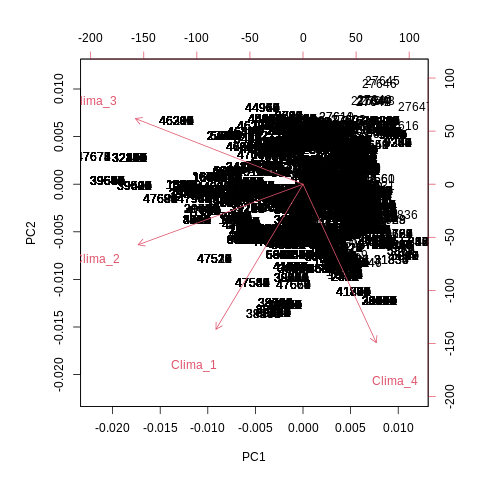

In [ ]:
%%R
biplot(pca.climate)

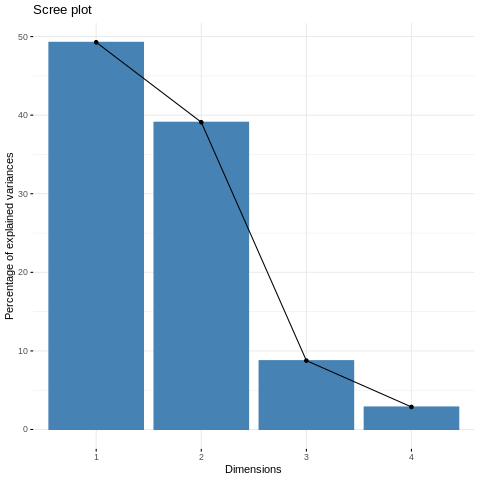

In [ ]:
%%R
fviz_eig(pca.climate)

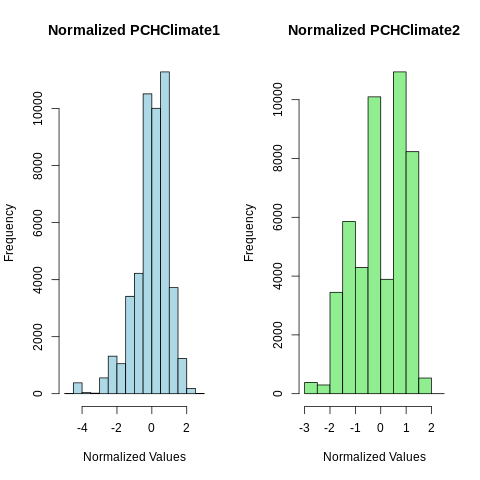

In [ ]:
%%R
## Axes
cor.clima.eixos <- pca.climate$rotation
eixos.pca <- pca.climate$x
data$PCHClimate1 <-  eixos.pca[,1]
data$PCHClimate2 <-  eixos.pca[,2]

par(mfrow = c(1, 2))
hist(normalize(data$PCHClimate1), main = "Normalized PCHClimate1", xlab = "Normalized Values", col = "lightblue")
hist(normalize(data$PCHClimate2), main = "Normalized PCHClimate2", xlab = "Normalized Values", col = "lightgreen")

# Reset layout
par(mfrow = c(1, 1))

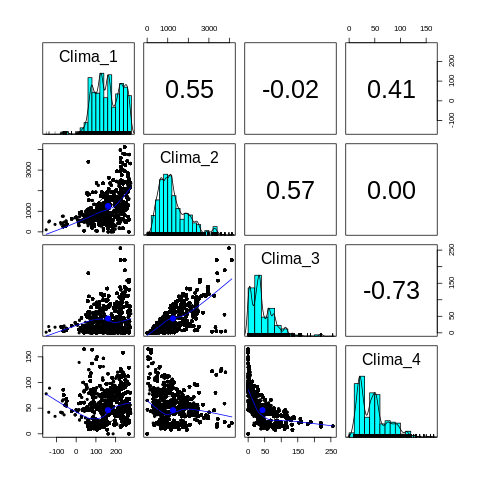

In [ ]:
%%R
## Autocorrelations
pairs.panels(data[,c("Clima_1","Clima_2","Clima_3","Clima_4")], method = "spearman")

In addition: Warning message:
In sqrt(data$Clima_1) : NaNs produced


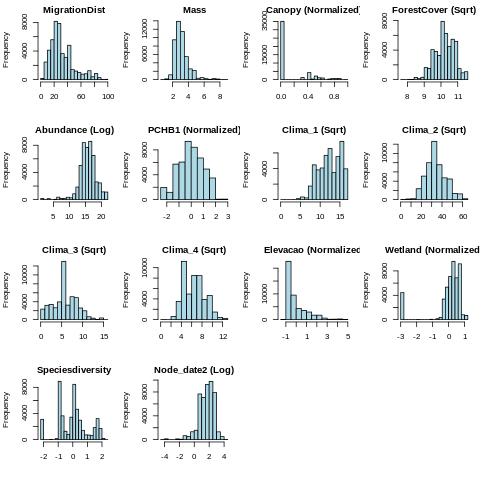

In [ ]:
%%R
## Histograms
# Set up a 4x4 grid layout for the plots
par(mfrow = c(4, 4), mar = c(4, 4, 2, 1))  # Adjust margins to fit all plots

# Plotting each histogram
hist(sqrt(data$MigrationDist), main = "MigrationDist", xlab = "", col = "lightblue")
hist(log(data$Mass), main = "Mass", xlab = "", col = "lightblue")
hist(sqrt(data$Canopy / 100), main = "Canopy (Normalized)", xlab = "", col = "lightblue")
hist(log(data$ForestCover), main = "ForestCover (Sqrt)", xlab = "", col = "lightblue")
hist(log(data$Abundance), main = "Abundance (Log)", xlab = "", col = "lightblue")
hist(normalize(data$PCHB1), main = "PCHB1 (Normalized)", xlab = "", col = "lightblue")
hist(sqrt(data$Clima_1), main = "Clima_1 (Sqrt)", xlab = "", col = "lightblue")
hist(sqrt(data$Clima_2), main = "Clima_2 (Sqrt)", xlab = "", col = "lightblue")
hist(sqrt(data$Clima_3), main = "Clima_3 (Sqrt)", xlab = "", col = "lightblue")
hist(sqrt(data$Clima_4), main = "Clima_4 (Sqrt)", xlab = "", col = "lightblue")
hist(normalize(data$Elevacao), main = "Elevacao (Normalized)", xlab = "", col = "lightblue")
hist(normalize(data$Wetland), main = "Wetland (Normalized)", xlab = "", col = "lightblue")
hist(normalize(data$Speciesdiversity), main = "Speciesdiversity", xlab = "", col = "lightblue")
hist(log(data$Node_date2), main = "Node_date2 (Log)", xlab = "", col = "lightblue")

# Reset layout
par(mfrow = c(1, 1))

In [ ]:
%%R
any(log(data$Mass) < 0)

[1] FALSE


In [ ]:
%%R
colnames(data)

 [1] "X"                  "Host.family"        "Avian.host.species"
 [4] "Latitude"           "Longitude"          "Country"           
 [7] "Year"               "Isolation.source"   "Protocol"          
[10] "Data.source"        "Plasmodium"         "Parahaemoproteus"  
[13] "Haemoproteus"       "Leucocytozoon"      "Site"              
[16] "MigrationDist"      "Canopy"             "Mass"              
[19] "ForestCover_2"      "ForestCover"        "Abundance"         
[22] "HB1"                "HB2"                "HB3"               
[25] "HB4"                "Clima_1"            "Clima_2"           
[28] "Clima_3"            "Clima_4"            "Elevacao"          
[31] "Wetland"            "Speciesdiversity"   "Node_date"         
[34] "Node_date2"         "PCHB1"              "phylo_id"          
[37] "PCHClimate1"        "PCHClimate2"       


# Checking if there's enough individuals per location

In [ ]:
%%R
colnames(data)

 [1] "X"                  "Host.family"        "Avian.host.species"
 [4] "Latitude"           "Longitude"          "Country"           
 [7] "Year"               "Isolation.source"   "Protocol"          
[10] "Data.source"        "Plasmodium"         "Parahaemoproteus"  
[13] "Haemoproteus"       "Leucocytozoon"      "Site"              
[16] "MigrationDist"      "Canopy"             "Mass"              
[19] "ForestCover_2"      "ForestCover"        "Abundance"         
[22] "HB1"                "HB2"                "HB3"               
[25] "HB4"                "Clima_1"            "Clima_2"           
[28] "Clima_3"            "Clima_4"            "Elevacao"          
[31] "Wetland"            "Speciesdiversity"   "Node_date"         
[34] "Node_date2"         "PCHB1"              "phylo_id"          
[37] "animal"            


In [ ]:
%%R
# Count individuals per species per site
counts <- data %>%
  dplyr::group_by(Avian.host.species, Site) %>%
  summarise(n_individuals = n(), .groups = "drop")

# See all counts
counts

# A tibble: 9,105 × 3
   Avian.host.species            Site n_individuals
   <chr>                        <int>         <int>
 1 Acanthisitta_chloris          1595             7
 2 Acanthiza_katherina           1569            19
 3 Acanthiza_pusilla             1562             5
 4 Acanthorhynchus_tenuirostris  1562             1
 5 Acanthorhynchus_tenuirostris  1568             3
 6 Acanthorhynchus_tenuirostris  1569            25
 7 Accipiter_nisus                215             1
 8 Accipiter_nisus                382             1
 9 Accipiter_nisus                395             1
10 Accipiter_nisus               1432             3
# ℹ 9,095 more rows
# ℹ Use `print(n = ...)` to see more rows


In [ ]:
%%R
# Check which species-site combos have at least 5 individuals
valid_counts <- counts %>%
  filter(n_individuals >= 5)

valid_counts

# A tibble: 2,107 × 3
   Avian.host.species            Site n_individuals
   <chr>                        <int>         <int>
 1 Acanthisitta_chloris          1595             7
 2 Acanthiza_katherina           1569            19
 3 Acanthiza_pusilla             1562             5
 4 Acanthorhynchus_tenuirostris  1569            25
 5 Acridotheres_tristis          1562           232
 6 Acridotheres_tristis          1577            27
 7 Acridotheres_tristis          1578            10
 8 Acrocephalus_arundinaceus     1309            41
 9 Acrocephalus_arundinaceus     1424            11
10 Acrocephalus_melanopogon      1309            67
# ℹ 2,097 more rows
# ℹ Use `print(n = ...)` to see more rows


In [ ]:
%%R
all_ok <- all(counts$n_individuals >= 5)
all_ok

[1] FALSE


In [ ]:
%%R
counts %>% filter(n_individuals < 5)

# A tibble: 6,998 × 3
   Avian.host.species            Site n_individuals
   <chr>                        <int>         <int>
 1 Acanthorhynchus_tenuirostris  1562             1
 2 Acanthorhynchus_tenuirostris  1568             3
 3 Accipiter_nisus                215             1
 4 Accipiter_nisus                382             1
 5 Accipiter_nisus                395             1
 6 Accipiter_nisus               1432             3
 7 Accipiter_nisus               1500             1
 8 Acridotheres_tristis          1559             1
 9 Acridotheres_tristis          1596             1
10 Acrocephalus_arundinaceus      215             2
# ℹ 6,988 more rows
# ℹ Use `print(n = ...)` to see more rows


In [ ]:
%%R
df_filtered <- data %>%
  group_by(Avian.host.species, Site) %>%
  filter(n() >= 5) %>%
  ungroup()

#**PLASMODIUM**

In [ ]:
%%R
## Multicolinearity
## Plasmodium
mod_plas_vif <- lm(Plasmodium ~ log(Mass) + log(Abundance) + log(ForestCover) +
    normalize(PCHB1) + normalize(Wetland) + sqrt(Canopy) +
    sqrt(Clima_2) + normalize(Elevacao) + log(Node_date) + normalize(Speciesdiversity) +
    Haemoproteus + Parahaemoproteus + Latitude, df_filtered)
VIF(mod_plas_vif)

                  log(Mass)              log(Abundance) 
                   1.230639                    1.856980 
           log(ForestCover)            normalize(PCHB1) 
                   1.224387                    1.598605 
         normalize(Wetland)                sqrt(Canopy) 
                   1.306916                    1.186024 
              sqrt(Clima_2)         normalize(Elevacao) 
                   1.303457                    1.148865 
             log(Node_date) normalize(Speciesdiversity) 
                   1.093648                    1.171686 
               Haemoproteus            Parahaemoproteus 
                   1.014959                    1.089879 
                   Latitude 
                   1.627199 


In [ ]:
%%R
# Create phylogenetic correlation matrix
A <- ape::vcv(phylogeny2, corr = TRUE)

In [ ]:
%%R
# Fit model using brms
mod_brms <- brm(
  Plasmodium ~ log(Mass) + log(Abundance) + log(ForestCover) +
    normalize(PCHB1) + normalize(Wetland) + sqrt(Canopy) +
    sqrt(Clima_2) + normalize(Elevacao) + log(Node_date) + normalize(Speciesdiversity) +
    Haemoproteus + Parahaemoproteus + Latitude + (1 | gr(Avian.host.species, cov = A)),
  data = df_filtered,
  data2    = list(A = A),
  family   = bernoulli(),
  chains   = 1,
  iter     = 4000,
  warmup   = 500,
  seed     = 636,
  control  = list(adapt_delta = 0.95)
)

In [ ]:
%%R
## Com dados resumidos
summary(mod_brms)

In [ ]:
%%R
mod_plas_null <- mod_brms <- brm(
  Plasmodium ~ 1 + (1 | gr(Avian.host.species, cov = A)),
  data = df_filtered,
  data2    = list(A = A),
  family   = bernoulli(),
  chains   = 1,
  iter     = 4000,
  warmup   = 500,
  seed     = 636,
  control  = list(adapt_delta = 0.95)
)

In [ ]:
%%R
loglik_full <- log_lik(mod_brms)      # matrix: iterations x observations
loglik_null <- log_lik(mod_plas_null)

# Compute WAIC or LOOIC (preferred over AIC in Bayesian setting)
waic_full <- waic(loglik_full)
waic_null <- waic(loglik_null)

loo_full <- loo(loglik_full)
loo_null <- loo(loglik_null)

# Compare models
loo_compare(loo_full, loo_null)

In [ ]:
%%R
# posterior predictive probabilities (mean across draws)
pred_mod_2 <- fitted(mod_brms, scale = "response")[, "Estimate"]

# observed outcome
obs_mod_2 <- mod_brms$data$Plasmodium

roc_mod_3 <- roc(
  response = obs_mod_2,
  predictor = pred_mod_2,
  percent   = TRUE,
  direction = "<",
  levels    = c(0, 1)
)

AUC <- auc(roc_mod_3)
AUC

Area under the curve: 81.91%


In [ ]:
%%R
# Best cutoff by Youden's J, from pROC (avoid masked coords)
roc_best <- pROC::coords(
  roc_mod_3,
  "best",
  best.method = "youden",
  ret = c("threshold", "sensitivity", "specificity"),
  transpose = FALSE
)

# If your ROC was built with percent=TRUE, rescale sens/spec to 0–1
if (!is.null(roc_mod_3$percent) && isTRUE(roc_mod_3$percent)) {
  roc_best[c("sensitivity","specificity")] <- roc_best[c("sensitivity","specificity")] / 100
}

roc_best

  threshold sensitivity specificity
1 0.1400928   0.7816045    0.696327


In [ ]:
%%R
# ensure 0–1 scale if percent=TRUE was used earlier
if (isTRUE(roc_mod_3$percent)) {
  roc_best[c("sensitivity","specificity")] <- roc_best[c("sensitivity","specificity")] / 100
}

TSS_2 <- as.numeric(roc_best[1, "sensitivity"]) + as.numeric(roc_best[1, "specificity"]) - 1
TSS_2

[1] -0.9852207


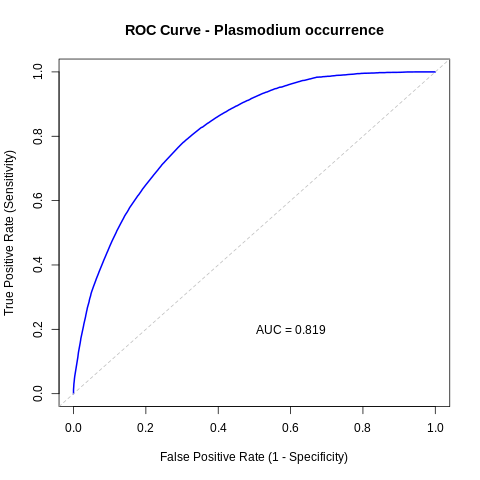

In [ ]:
%%R
# wrap data
pred <- ROCR::prediction(pred_mod_2, obs_mod_2)

# ROC performance object
perf <- ROCR::performance(pred, measure = "tpr", x.measure = "fpr")

# plot ROC
plot(perf,
     col = "blue", lwd = 2,
     main = "ROC Curve - Plasmodium occurrence",
     xlab = "False Positive Rate (1 - Specificity)",
     ylab = "True Positive Rate (Sensitivity)")
abline(a = 0, b = 1, lty = 2, col = "gray")

# add AUC
auc_perf <- ROCR::performance(pred, measure = "auc")
auc_val  <- auc_perf@y.values[[1]]
text(0.6, 0.2, paste("AUC =", round(auc_val, 3)))

#**Haemoproteus**

In [ ]:
%%R
# same transforms you used in pglmm
normalize <- function(x) as.numeric(scale(x))

# make sure the tree uses $tip.label
tips <- phylogeny2$tip.label %||% phylogeny2$Tip.label
phylogeny2$tip.label <- tips

# species factor that matches the tree
data$animal <- factor(as.character(data$Avian.host.species), levels = phylogeny2$tip.label)

# phylogenetic covariance (correlation is fine)
library(ape)
A <- ape::vcv(phylogeny2, corr = TRUE)
A <- A[levels(data$animal), levels(data$animal)]  # reorder to match factor levels

# binary response expected by brms
if (is.factor(data$Haemoproteus)) {
  data$Haemoproteus <- as.integer(data$Haemoproteus) - 1  # 0/1
}

In [ ]:
%%R
## Haemoproteus: remove sqrt(Clima_3) and sqrt(Clima_1)
mod_hae_vif <- lm(Haemoproteus ~ normalize(MigrationDist) + log(Mass) +
                  log(ForestCover) + log(Abundance) + normalize(PCHB1) + normalize(Canopy) +
                  normalize(Wetland) + sqrt(Clima_2) + sqrt(Clima_4) +
                  normalize(Elevacao) + normalize(Speciesdiversity) + log(Node_date) +
                  Plasmodium + Parahaemoproteus +
                Latitude, data)
VIF(mod_hae_vif)

   normalize(MigrationDist)                   log(Mass) 
                   1.364226                    1.161302 
           log(ForestCover)              log(Abundance) 
                   1.234728                    1.893146 
           normalize(PCHB1)           normalize(Canopy) 
                   1.538249                    1.108494 
         normalize(Wetland)               sqrt(Clima_2) 
                   1.318042                    1.352506 
              sqrt(Clima_4)         normalize(Elevacao) 
                   1.340371                    1.310048 
normalize(Speciesdiversity)              log(Node_date) 
                   1.175327                    1.062599 
                 Plasmodium            Parahaemoproteus 
                   1.039960                    1.083486 
                   Latitude 
                   1.620575 


In [ ]:
%%R
bf_hae <- bf(
  Haemoproteus ~ normalize(MigrationDist) + log(Mass) +
    log(ForestCover) + log(Abundance) + normalize(PCHB1) + normalize(Canopy) +
    normalize(Wetland) + sqrt(Clima_2) + sqrt(Clima_4) +
    normalize(Elevacao) + normalize(Speciesdiversity) + log(Node_date) +
    Plasmodium + Latitude +
    (1 | gr(animal, cov = A))
)

In [ ]:
%%R
fit_hae <- brm(
  formula  = bf_hae,
  data = df_filtered,
  data2    = list(A = A),
  family   = bernoulli(),
  chains   = 1,
  iter     = 4000,
  warmup   = 500,
  seed     = 636,
  control  = list(adapt_delta = 0.95)
)

In [ ]:
%%R
summary(fit_hae)

In [ ]:
%%R
## Null model
bf_null <- bf(
  Haemoproteus ~ 1 + (1 | gr(animal, cov = A))
)

fit_null <- brm(
  formula  = bf_null,
  data     = data,
  data2    = list(A = A),
  family   = bernoulli(link = "logit"),
  chains   = 4, cores = 4, iter = 2000, warmup = 1000,
  control  = list(adapt_delta = 0.95, max_treedepth = 12),
  seed     = 1
)

In [ ]:
%%R
loo_full <- loo(fit_hae)
loo_null <- loo(fit_null)

In [ ]:
%%R
lc <- loo_compare(loo_full, loo_null)
print(lc)

       elpd_diff se_diff
model1 0.0       0.0    
model2 0.0       0.0    


In [ ]:
%%R
# posterior predictive probabilities (mean across draws)
pred_mod_2 <- fitted(fit_hae, scale = "response")[, "Estimate"]

# observed outcome
obs_mod_2 <- fit_hae$data$Haemoproteus

roc_mod_3 <- roc(
  response = obs_mod_2,
  predictor = pred_mod_2,
  percent   = TRUE,
  direction = "<",
  levels    = c(0, 1)
)

AUC <- auc(roc_mod_3)
AUC

Area under the curve: 99.61%


In [ ]:
%%R
# Best cutoff by Youden's J, from pROC (avoid masked coords)
roc_best <- pROC::coords(
  roc_mod_3,
  "best",
  best.method = "youden",
  ret = c("threshold", "sensitivity", "specificity"),
  transpose = FALSE
)

# If your ROC was built with percent=TRUE, rescale sens/spec to 0–1
if (!is.null(roc_mod_3$percent) && isTRUE(roc_mod_3$percent)) {
  roc_best[c("sensitivity","specificity")] <- roc_best[c("sensitivity","specificity")] / 100
}

roc_best

    threshold sensitivity specificity
1 0.004362748           1   0.9636221


In [ ]:
%%R
# ensure 0–1 scale if percent=TRUE was used earlier
if (isTRUE(roc_mod_3$percent)) {
  roc_best[c("sensitivity","specificity")] <- roc_best[c("sensitivity","specificity")] / 100
}

TSS_2 <- as.numeric(roc_best[1, "sensitivity"]) + as.numeric(roc_best[1, "specificity"]) - 1
TSS_2

[1] -0.9803638


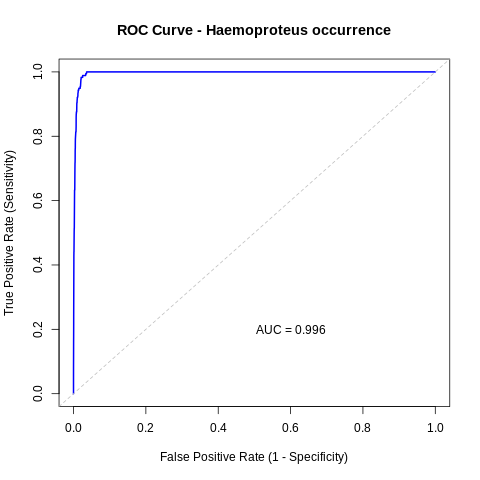

In [ ]:
%%R
# wrap data
pred <- ROCR::prediction(pred_mod_2, obs_mod_2)

# ROC performance object
perf <- ROCR::performance(pred, measure = "tpr", x.measure = "fpr")

# plot ROC
plot(perf,
     col = "blue", lwd = 2,
     main = "ROC Curve - Haemoproteus occurrence",
     xlab = "False Positive Rate (1 - Specificity)",
     ylab = "True Positive Rate (Sensitivity)")
abline(a = 0, b = 1, lty = 2, col = "gray")

# add AUC
auc_perf <- ROCR::performance(pred, measure = "auc")
auc_val  <- auc_perf@y.values[[1]]
text(0.6, 0.2, paste("AUC =", round(auc_val, 3)))

##**Parahaemoproteus**

In [ ]:
%%R
## Parahaemoproteus
mod_para_vif <- lm(Parahaemoproteus ~ normalize(MigrationDist) + log(Mass) +
                  log(ForestCover) + log(Abundance) + normalize(PCHB1) + normalize(Canopy) +
                  normalize(Wetland) + sqrt(Clima_2) + sqrt(Clima_4) +
                  normalize(Elevacao) + normalize(Speciesdiversity) + log(Node_date) + Plasmodium, data)
vif(mod_para_vif)

   normalize(MigrationDist)                   log(Mass) 
                   1.309744                    1.114974 
           log(ForestCover)              log(Abundance) 
                   1.219246                    1.799639 
           normalize(PCHB1)           normalize(Canopy) 
                   1.533927                    1.086713 
         normalize(Wetland)               sqrt(Clima_2) 
                   1.207491                    1.306867 
              sqrt(Clima_4)         normalize(Elevacao) 
                   1.335953                    1.305683 
normalize(Speciesdiversity)              log(Node_date) 
                   1.173402                    1.062257 
                 Plasmodium 
                   1.024989 


In [ ]:
%%R
# same transforms you used in pglmm
normalize <- function(x) as.numeric(scale(x))

# make sure the tree uses $tip.label
tips <- phylogeny2_pruned$tip.label %||% phylogeny2_pruned$Tip.label
phylogeny2_pruned$tip.label <- tips

# species factor that matches the tree
data_filtered$animal <- factor(as.character(data_filtered$Avian.host.species), levels = phylogeny2_pruned$tip.label)

# phylogenetic covariance (correlation is fine)
library(ape)
A <- ape::vcv(phylogeny2_pruned, corr = TRUE)
A <- A[levels(data_filtered$animal), levels(data_filtered$animal)]  # reorder to match factor levels

# binary response expected by brms
if (is.factor(data_filtered$Parahaemoproteus)) {
  data_filtered$Parahaemoproteus <- as.integer(data_filtered$Parahaemoproteus) - 1  # 0/1
}

In [ ]:
%%R
## ---------- 1) Full model (same predictors as your pglmm) ----------
bf_para <- bf(
  Parahaemoproteus ~
    log(Mass) +
    log(ForestCover) + log(Abundance) +
    normalize(PCHB1) + normalize(Canopy) +
    normalize(Wetland) +
    normalize(Speciesdiversity) +
    log(Node_date) + Plasmodium + Latitude +
    (1 | gr(animal, cov = A))
)

In [ ]:
%%R
fit_test <- brm(
  formula  = bf_para,
  data = df_filtered,
  data2    = list(A = A),
  family   = bernoulli(),
  chains   = 1,
  iter     = 4000,
  warmup   = 500,
  seed     = 636,
  control  = list(adapt_delta = 0.95)
)

In [ ]:
%%R
summary(fit_test)

In [ ]:
%%R
## ---------- 2) Null model (intercept + phylo RE only) ----------
bf_para_null <- bf(Parahaemoproteus ~ 1 + (1 | gr(animal, cov = A)))

fit_para_null <- brm(
  formula  = bf_para_null,
  data     = data,
  data2    = list(A = A),
  family   = bernoulli(link = "logit"),
  chains   = 4, cores = 4, iter = 2000, warmup = 1000,
  control  = list(adapt_delta = 0.95, max_treedepth = 12),
  seed     = 3
)

In [ ]:
%%R
## ---------- 4) Predicted probabilities & ROC/AUC ----------
# mean posterior predictive probabilities
pred_para <- fitted(fit_para, scale = "response")[, "Estimate"]
obs_para  <- fit_para$data$Parahaemoproteus

roc_para <- pROC::roc(
  response = obs_para,
  predictor = pred_para,
  percent   = TRUE,         # to match your previous workflow
  direction = "<",
  levels    = c(0, 1)
)
AUC_para <- pROC::auc(roc_para); AUC_para

Area under the curve: 87.54%


In [ ]:
%%R
## ---------- 5) Best cutoff, sens/spec, TSS ----------
best_para <- pROC::coords(
  roc_para, "best", best.method = "youden",
  ret = c("threshold","sensitivity","specificity"),
  transpose = FALSE
)
# rescale to 0–1 if percent=TRUE
best_para[c("sensitivity","specificity")] <- best_para[c("sensitivity","specificity")] / 100
TSS_para <- as.numeric(best_para[1,"sensitivity"]) + as.numeric(best_para[1,"specificity"]) - 1
best_para; TSS_para


[1] 0.6009355


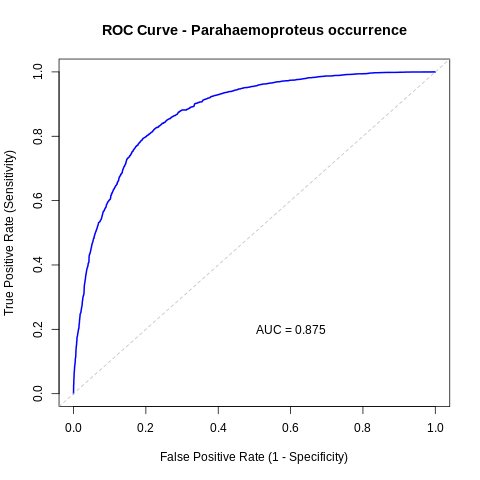

In [ ]:
%%R
## ---------- 6) ROC curve (ROCR style) ----------
pred_obj <- ROCR::prediction(pred_para, obs_para)
perf_obj <- ROCR::performance(pred_obj, measure = "tpr", x.measure = "fpr")

plot(perf_obj,
     col = "blue", lwd = 2,
     main = "ROC Curve - Parahaemoproteus occurrence",
     xlab = "False Positive Rate (1 - Specificity)",
     ylab = "True Positive Rate (Sensitivity)")
abline(a = 0, b = 1, lty = 2, col = "gray")
auc_rocr <- ROCR::performance(pred_obj, measure = "auc")@y.values[[1]]
text(0.6, 0.2, paste("AUC =", round(auc_rocr, 3)))